In [16]:
import pandas as pd
from pandas import DataFrame
import numpy as np 

In [15]:
price_data = pd.read_csv("sample_data/prices_round_1_day_-2.csv", sep=";")
print(price_data.head())
print(price_data.shape)
pd.set_option('display.max_rows', None)

   day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
0   -2          0  AMETHYSTS         9996             1       9995.0   
1   -2          0  STARFRUIT         4997            26          NaN   
2   -2        100  AMETHYSTS        10000             5       9995.0   
3   -2        100  STARFRUIT         5000             5       4998.0   
4   -2        200  STARFRUIT         4997             1       4996.0   

   bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0          25.0          NaN           NaN        10004             1   
1           NaN          NaN           NaN         5003            26   
2          20.0          NaN           NaN        10005            20   
3           6.0       4997.0          20.0         5004            20   
4          30.0          NaN           NaN         5003            31   

   ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
0      10005.0          25.0          NaN           NaN   

## Trading Algorithms 
1. condense the prices data from round_1 starting from day -2 to -1 to 0 
2. aggregate the trades data from round_1  
3. Write trading strategies starting with basic directionality long/short predictions: pairs trading with stationarity/ cointegration (ARIMA?), mean reversion, momentum, volalitilty, etc.
    - start with algorithmic trading on the mid_price data only (to predict the true value of the actual price)
    - Then consider how to factor in individual order sizes from other market traders for both buy and sell orders, paying special attention to the volume of the orders in addition to the price 
4. backtest and implement calculations unrealized PNL and total PNL
5. Then augment with position sizing calculus for algorithms that show promise
    - One idea is to incorporate volume/volatility based calculations in position sizing 

### Step 1
Aggregate price data

In [35]:
price_data = pd.concat([pd.read_csv("sample_data/prices_round_1_day_-2.csv", sep=";"), pd.read_csv("sample_data/prices_round_1_day_-1.csv", sep=";"),pd.read_csv("sample_data/prices_round_1_day_0.csv", sep=";")], ignore_index=True)

print(price_data.shape)

(60000, 17)


In [36]:
import matplotlib.pyplot as plt

# graph the price data for all the days
def plot_price_data_per_product(product1 :str, product2 :str, df :DataFrame, y_range_product1=None, y_range_product2=None):
    """
    Plots the price data per product by their mid_price. Uses row index as x-axis, and assumes the existence of a mid_price per product
    - products: the str value of the products
    - df: the dataframe data
    """
    product1_data = df[df['product'] == product1]
    product2_data =df[df['product'] == product2]

    fig, ax1 = plt.subplots(figsize=(12, 8))

    color = 'tab:blue'
    ax1.set_xlabel('Index')
    ax1.set_ylabel(f'{product1} Price', color=color)
    ax1.set
    ax1.plot(product1_data.index / 2, product1_data['mid_price'], label=f"{product1}_Mid_Price", color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.ticklabel_format(useOffset=False, style='plain')
    if y_range_product1:
        ax1.set_ylim(y_range_product1)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:orange'
    ax2.set_ylabel(f'{product2} Price', color=color)  # we already handled the x-label with ax1
    ax2.plot(product2_data.index / 2, product2_data['mid_price'], label=f"{product2}_Mid_Price", color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.ticklabel_format(useOffset=False, style='plain')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.suptitle('Price Data Comparison', fontsize=16, y=1.02)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.show()

    """
    plt.figure(figsize=(12, 8))
    plt.plot(product1_data.index / 2, product1_data['mid_price'], label=f"{product1}_Mid_Price", color="blue")    
    plt.plot(product2_data.index / 2, product2_data['mid_price'], label=f"{product2}_Mid_Price", color="orange")

    plt.ticklabel_format(useOffset=False, style='plain')

    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.title('Price_Data')
    plt.legend()
    plt.grid(True)
    plt.show()
    """

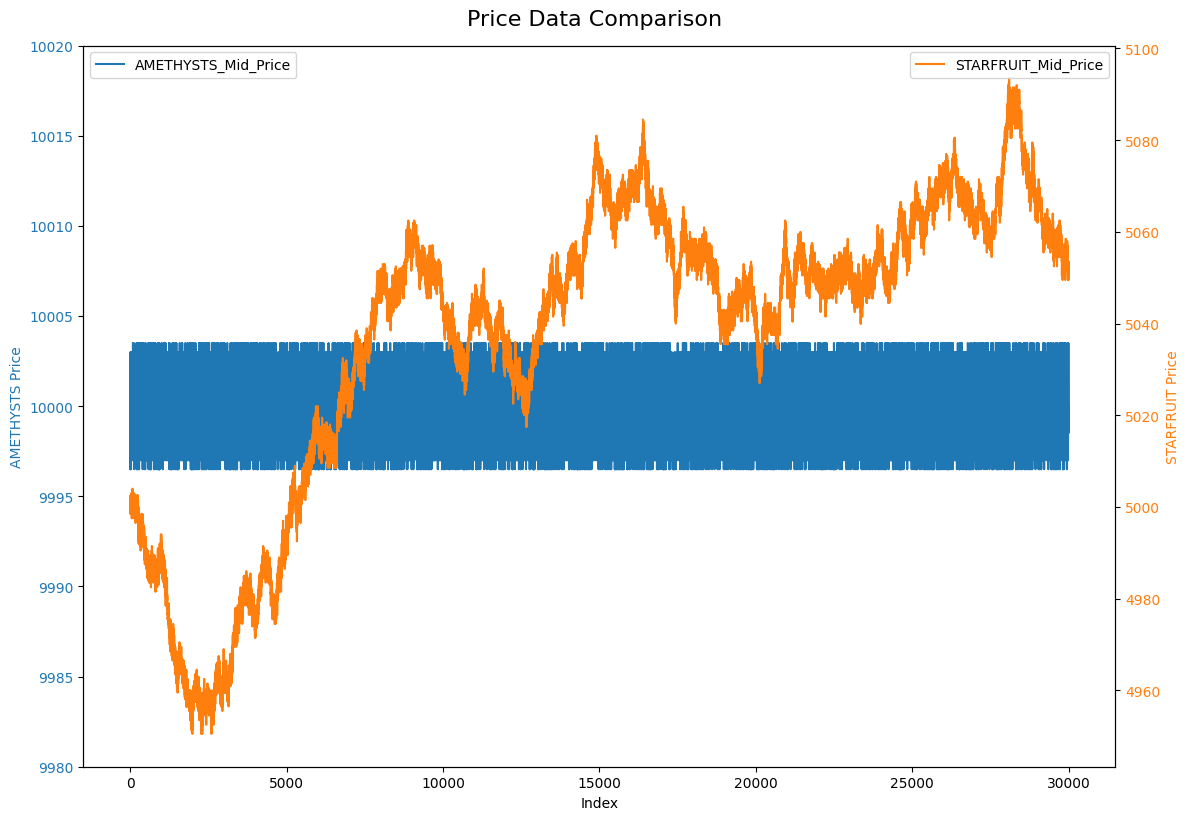

In [37]:
plot_price_data_per_product("AMETHYSTS","STARFRUIT", price_data, [9980,10020])

### Step 2
Aggregate and analyze Trade data

In [41]:
trades_data = pd.concat([pd.read_csv("sample_data/trades_round_1_day_-2_nn.csv", sep=";"), pd.read_csv("sample_data/trades_round_1_day_-1_nn.csv", sep=";"),pd.read_csv("sample_data/trades_round_1_day_0_nn.csv", sep=";")], ignore_index=True)
print(trades_data.shape)
print(trades_data.head())


(16150, 7)
   timestamp  buyer  seller     symbol   currency   price  quantity
0          0    NaN     NaN  AMETHYSTS  SEASHELLS  9996.0         1
1          0    NaN     NaN  STARFRUIT  SEASHELLS  5003.0         1
2          0    NaN     NaN  AMETHYSTS  SEASHELLS  9996.0         1
3        100    NaN     NaN  STARFRUIT  SEASHELLS  5004.0         6
4        900    NaN     NaN  STARFRUIT  SEASHELLS  5001.0         2
